In [1]:
!pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 58.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, r2_score
from itertools import product

## FUNCIONES AUXILIARES

In [3]:
def predecir_n_meses(model, X_actual, exog_vars, n_meses):
    """ Predice la inflación mensual para los próximos 'n_meses' """

    # 📌 Convertir el índice de X_actual a `DatetimeIndex` si no lo es
    if not isinstance(X_actual.index, pd.DatetimeIndex):
        X_actual.index = pd.to_datetime(X_actual.index)

    # 📌 Definir fechas futuras
    inicio_pred = X_actual.index[-1] + pd.DateOffset(months=1)
    fechas_futuras = pd.date_range(start=inicio_pred, periods=n_meses, freq="ME")

    # 📌 Ajustar el índice de fechas futuras según el modelo
    if isinstance(model.data.row_labels, pd.PeriodIndex):
        fechas_futuras = fechas_futuras.to_period('M')  # Convertir a PeriodIndex
    elif isinstance(model.data.row_labels, pd.Index) and model.data.row_labels.dtype == "int64":
        fechas_futuras = range(model.data.row_labels[-1] + 1, model.data.row_labels[-1] + 1 + n_meses)

    # 📌 Generar datos exógenos futuros replicando la última fila de X_actual
    X_future = pd.DataFrame([X_actual.iloc[-1].values] * n_meses,
                            columns=X_actual.columns, index=fechas_futuras)

    # 📌 Predecir valores futuros asegurando compatibilidad del índice
    y_futuro = model.predict(start=fechas_futuras[0], end=fechas_futuras[-1], exog=X_future[exog_vars])

    return pd.DataFrame({'Fecha': fechas_futuras, 'Predicción': y_futuro.values})


In [4]:
def smape(y_true, y_pred):
    """ Calcula el Symmetric Mean Absolute Percentage Error (SMAPE) """
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

## PREPROCESAMIENTO

In [5]:
df = pd.read_csv("/content/Data_Econocast - Hoja 1.csv")

In [6]:
meses = {'enero': 1, 'febrero':2, 'marzo':3, 'abril': 4, 'mayo':5, 'junio': 6,
         'julio':7, 'agosto': 8, 'septiembre': 9, 'octubre':10, 'noviembre': 11, 'diciembre':12}

In [7]:
df['mes_num'] = df['mes'].str.lower().map(meses)

In [8]:
df['fecha'] = pd.to_datetime({'year': df['anio'], 'month': df['mes_num'], 'day': 1})

In [9]:
df.sort_values('fecha', inplace=True)

### Calculo de la inflación

In [10]:
# Calcular la inflación
df["Inflación Mensual (%)"] = df["indice_ipc_general"].pct_change() * 100
df["Inflación Interanual (%)"] = df["indice_ipc_general"].pct_change(periods=12) * 100

In [11]:
# Convertir x rubros

# alimentos_bebidas_sin_alcohol
df["alimentos_bebidas_sin_alcohol M(%)"] = df["alimentos_bebidas_sin_alcohol"].pct_change() * 100
df["alimentos_bebidas_sin_alcohol I(%)"] = df["alimentos_bebidas_sin_alcohol"].pct_change(periods=12) * 100

# bebidas_alcoholicas_tabaco
df["bebidas_alcoholicas_tabaco M(%)"] = df["bebidas_alcoholicas_tabaco"].pct_change() * 100
df["bebidas_alcoholicas_tabaco I(%)"] = df["bebidas_alcoholicas_tabaco"].pct_change(periods=12) * 100

# prendas_de_vestir_calzado
df["prendas_de_vestir_calzado M(%)"] = df["prendas_de_vestir_calzado"].pct_change() * 100
df["prendas_de_vestir_calzado I(%)"] = df["prendas_de_vestir_calzado"].pct_change(periods=12) * 100

# alojamiento_agua_electricidad_gas_otroscomb
df["alojamiento_agua_electricidad_gas_otroscomb M(%)"] = df["alojamiento_agua_electricidad_gas_otroscomb"].pct_change() * 100
df["alojamiento_agua_electricidad_gas_otroscomb I(%)"] = df["alojamiento_agua_electricidad_gas_otroscomb"].pct_change(periods=12) * 100

# muebles_articulos_hogar
df["muebles_articulos_hogar M(%)"] = df["muebles_articulos_hogar"].pct_change() * 100
df["muebles_articulos_hogar I(%)"] = df["muebles_articulos_hogar"].pct_change(periods=12) * 100

# salud
df["salud M(%)"] = df["salud"].pct_change() * 100
df["salud I(%)"] = df["salud"].pct_change(periods=12) * 100

# transporte
df["transporte M(%)"] = df["transporte"].pct_change() * 100
df["transporte I(%)"] = df["transporte"].pct_change(periods=12) * 100

# comunicaciones
df["comunicaciones M(%)"] = df["comunicaciones"].pct_change() * 100
df["comunicaciones I(%)"] = df["comunicaciones"].pct_change(periods=12) * 100

# recreacion _cultura
df["recreacion _cultura M(%)"] = df["recreacion _cultura"].pct_change() * 100
df["recreacion _cultura I(%)"] = df["recreacion _cultura"].pct_change(periods=12) * 100

# educacion
df["educacion M(%)"] = df["educacion"].pct_change() * 100
df["educacion I(%)"] = df["educacion"].pct_change(periods=12) * 100

# restaurantes_hoteles
df["restaurantes_hoteles M(%)"] = df["restaurantes_hoteles"].pct_change() * 100
df["restaurantes_hoteles I(%)"] = df["restaurantes_hoteles"].pct_change(periods=12) * 100

# cuidado_personal
df["cuidado_personal M(%)"] = df["cuidado_personal"].pct_change() * 100
df["cuidado_personal I(%)"] = df["cuidado_personal"].pct_change(periods=12) * 10


### NAs

In [12]:
# Inflación Mensual (%)
df[['Inflación Mensual (%)', 'Inflación Interanual (%)']] = df[['Inflación Mensual (%)', 'Inflación Interanual (%)']].ffill()
df[['Inflación Mensual (%)', 'Inflación Interanual (%)']] = df[['Inflación Mensual (%)', 'Inflación Interanual (%)']].bfill()

In [13]:
# alimentos_bebidas_sin_alcohol
df[['alimentos_bebidas_sin_alcohol M(%)', 'alimentos_bebidas_sin_alcohol I(%)']] = df[['alimentos_bebidas_sin_alcohol M(%)', 'alimentos_bebidas_sin_alcohol I(%)']].ffill()
df[['alimentos_bebidas_sin_alcohol M(%)', 'alimentos_bebidas_sin_alcohol I(%)']] = df[['alimentos_bebidas_sin_alcohol M(%)', 'alimentos_bebidas_sin_alcohol I(%)']].bfill()

# bebidas_alcoholicas_tabaco
df[['bebidas_alcoholicas_tabaco M(%)', 'bebidas_alcoholicas_tabaco I(%)']] = df[['bebidas_alcoholicas_tabaco M(%)', 'bebidas_alcoholicas_tabaco I(%)']].ffill()
df[['bebidas_alcoholicas_tabaco M(%)', 'bebidas_alcoholicas_tabaco I(%)']] = df[['bebidas_alcoholicas_tabaco M(%)', 'bebidas_alcoholicas_tabaco I(%)']].bfill()

# prendas_de_vestir_calzado
df[['prendas_de_vestir_calzado M(%)', 'prendas_de_vestir_calzado I(%)']] = df[['prendas_de_vestir_calzado M(%)', 'prendas_de_vestir_calzado I(%)']].ffill()
df[['prendas_de_vestir_calzado M(%)', 'prendas_de_vestir_calzado I(%)']] = df[['prendas_de_vestir_calzado M(%)', 'prendas_de_vestir_calzado I(%)']].bfill()

# alojamiento_agua_electricidad_gas_otroscomb
df[['alojamiento_agua_electricidad_gas_otroscomb M(%)', 'alojamiento_agua_electricidad_gas_otroscomb I(%)']] = df[['alojamiento_agua_electricidad_gas_otroscomb M(%)', 'alojamiento_agua_electricidad_gas_otroscomb I(%)']].ffill()
df[['alojamiento_agua_electricidad_gas_otroscomb M(%)', 'alojamiento_agua_electricidad_gas_otroscomb I(%)']] = df[['alojamiento_agua_electricidad_gas_otroscomb M(%)', 'alojamiento_agua_electricidad_gas_otroscomb I(%)']].bfill()

# muebles_articulos_hogar
df[['muebles_articulos_hogar M(%)', 'muebles_articulos_hogar I(%)']] = df[['muebles_articulos_hogar M(%)', 'muebles_articulos_hogar I(%)']].ffill()
df[['muebles_articulos_hogar M(%)', 'muebles_articulos_hogar I(%)']] = df[['muebles_articulos_hogar M(%)', 'muebles_articulos_hogar I(%)']].bfill()

# salud
df[['salud M(%)', 'salud I(%)']] = df[['salud M(%)', 'salud I(%)']].ffill()
df[['salud M(%)', 'salud I(%)']] = df[['salud M(%)', 'salud I(%)']].bfill()

# transporte
df[['transporte M(%)', 'transporte I(%)']] = df[['transporte M(%)', 'transporte I(%)']].ffill()
df[['transporte M(%)', 'transporte I(%)']] = df[['transporte M(%)', 'transporte I(%)']].bfill()

# comunicaciones
df[['comunicaciones M(%)', 'comunicaciones I(%)']] = df[['comunicaciones M(%)', 'comunicaciones I(%)']].ffill()
df[['comunicaciones M(%)', 'comunicaciones I(%)']] = df[['comunicaciones M(%)', 'comunicaciones I(%)']].bfill()

# recreacion _cultura
df[['recreacion _cultura M(%)', 'recreacion _cultura I(%)']] = df[['recreacion _cultura M(%)', 'recreacion _cultura I(%)']].ffill()
df[['recreacion _cultura M(%)', 'recreacion _cultura I(%)']] = df[['recreacion _cultura M(%)', 'recreacion _cultura I(%)']].bfill()

# educacion
df[['educacion M(%)', 'educacion I(%)']] = df[['educacion M(%)', 'educacion I(%)']].ffill()
df[['educacion M(%)', 'educacion I(%)']] = df[['educacion M(%)', 'educacion I(%)']].bfill()

# restaurantes_hoteles
df[['restaurantes_hoteles M(%)', 'restaurantes_hoteles I(%)']] = df[['restaurantes_hoteles M(%)', 'restaurantes_hoteles I(%)']].ffill()
df[['restaurantes_hoteles M(%)', 'restaurantes_hoteles I(%)']] = df[['restaurantes_hoteles M(%)', 'restaurantes_hoteles I(%)']].bfill()

# cuidado_personal
df[['cuidado_personal M(%)', 'cuidado_personal I(%)']] = df[['cuidado_personal M(%)', 'cuidado_personal I(%)']].ffill()
df[['cuidado_personal M(%)', 'cuidado_personal I(%)']] = df[['cuidado_personal M(%)', 'cuidado_personal I(%)']].bfill()


In [14]:
df[['alimentos_bebidas_sin_alcohol M(%)', 'alimentos_bebidas_sin_alcohol I(%)']]

,alimentos_bebidas_sin_alcohol M(%),alimentos_bebidas_sin_alcohol I(%)
0,4.911839,20.403023
1,4.911839,20.403023
2,1.840736,20.403023
3,1.728880,20.403023
4,2.742372,20.403023
...,...,...
404,-0.893522,4.419456
405,-0.976709,2.701299
406,-0.025291,1.986584
407,0.581837,1.480347


In [15]:
df['precio_promedio_venta_USD'] = df['precio_promedio_venta_USD'].fillna(df['precio_promedio_venta_USD'].median())
df['promedio_valor_USD_anual'] = df['promedio_valor_USD_anual'].fillna(df['promedio_valor_USD_anual'].median())

In [16]:
df['importaciones_valor_usd'] = (
    df['importaciones_valor_usd']
    .str.replace(',', '', regex=True)  # Elimina las comas de los números
    .astype(float)  # Convierte a tipo numérico
)

df['importaciones_valor_usd'] = df['importaciones_valor_usd'].fillna(df['importaciones_valor_usd'].median())

In [17]:
df['importaciones_volumen_kg'] = (
    df['importaciones_volumen_kg']
    .str.replace(',', '', regex=True)  # Elimina las comas de los números
    .astype(float)  # Convierte a tipo numérico
)

df['importaciones_volumen_kg'] = df['importaciones_volumen_kg'].fillna(df['importaciones_volumen_kg'].median())

In [18]:
# Eliminar comas y convertir a tipo numérico
df['exportaciones_valor_usd'] = (
    df['exportaciones_valor_usd']
    .astype(str)  # Asegura que todos los valores sean cadenas
    .str.replace(',', '', regex=True)  # Elimina las comas
    .astype(float)  # Convierte a tipo float
)

# Rellenar valores nulos con la mediana
df['exportaciones_valor_usd'] = df['exportaciones_valor_usd'].fillna(df['exportaciones_valor_usd'].median())

In [19]:
# Eliminar comas y convertir a tipo numérico
df['exportaciones_volumen_kg'] = (
    df['exportaciones_volumen_kg']
    .astype(str)  # Asegura que todos los valores sean cadenas
    .str.replace(',', '', regex=True)  # Elimina las comas
    .astype(float)  # Convierte a tipo float
)

# Rellenar valores nulos con la mediana
df['exportaciones_volumen_kg'] = df['exportaciones_volumen_kg'].fillna(df['exportaciones_volumen_kg'].median())

## SPLIT

In [20]:
features = df.drop(columns=['Inflación Mensual (%)', 'anio', 'mes', 'fecha'])
target = df['Inflación Mensual (%)']

In [21]:
train = df[df['anio'] <= 2019]
val = df[(df['anio'] >= 2020) & (df['anio'] <= 2021)]
test = df[(df['anio'] >= 2022) & (df['anio'] <= 2023)]
set2024 = df[df['anio'] >= 2024]

In [22]:
X_train, y_train = train[features.columns], train[target.name]
X_val, y_val = val[features.columns], val[target.name]
X_test, y_test = test[features.columns], test[target.name]
X_2024, y_2024 = set2024[features.columns], set2024[target.name]

## VARIABLES EXOGENAS (sin = 'indice_ipc_general')

In [23]:
X_train.columns

Index(['precio_promedio_venta_USD', 'promedio_valor_USD_anual',
       'alimentos_bebidas_sin_alcohol', 'bebidas_alcoholicas_tabaco',
       'prendas_de_vestir_calzado',
       'alojamiento_agua_electricidad_gas_otroscomb',
       'muebles_articulos_hogar', 'salud', 'transporte', 'comunicaciones',
       'recreacion _cultura', 'educacion', 'restaurantes_hoteles',
       'cuidado_personal', 'indice_ipc_general', 'importaciones_valor_usd',
       'importaciones_volumen_kg', 'exportaciones_valor_usd',
       'exportaciones_volumen_kg', 'mes_num', 'Inflación Interanual (%)',
       'alimentos_bebidas_sin_alcohol M(%)',
       'alimentos_bebidas_sin_alcohol I(%)', 'bebidas_alcoholicas_tabaco M(%)',
       'bebidas_alcoholicas_tabaco I(%)', 'prendas_de_vestir_calzado M(%)',
       'prendas_de_vestir_calzado I(%)',
       'alojamiento_agua_electricidad_gas_otroscomb M(%)',
       'alojamiento_agua_electricidad_gas_otroscomb I(%)',
       'muebles_articulos_hogar M(%)', 'muebles_articulos_hoga

In [24]:
exog_vars = ['precio_promedio_venta_USD', 'promedio_valor_USD_anual',
       'importaciones_valor_usd',
       'importaciones_volumen_kg', 'exportaciones_valor_usd',
       'exportaciones_volumen_kg', 'mes_num', 'Inflación Interanual (%)',
       'alimentos_bebidas_sin_alcohol M(%)',
       'alimentos_bebidas_sin_alcohol I(%)', 'bebidas_alcoholicas_tabaco M(%)',
       'bebidas_alcoholicas_tabaco I(%)', 'prendas_de_vestir_calzado M(%)',
       'prendas_de_vestir_calzado I(%)',
       'alojamiento_agua_electricidad_gas_otroscomb M(%)',
       'alojamiento_agua_electricidad_gas_otroscomb I(%)',
       'muebles_articulos_hogar M(%)', 'muebles_articulos_hogar I(%)',
       'salud M(%)', 'salud I(%)', 'transporte M(%)', 'transporte I(%)',
       'comunicaciones M(%)', 'comunicaciones I(%)',
       'recreacion _cultura M(%)', 'recreacion _cultura I(%)',
       'educacion M(%)', 'educacion I(%)', 'restaurantes_hoteles M(%)',
       'restaurantes_hoteles I(%)', 'cuidado_personal M(%)',
       'cuidado_personal I(%)']

## MODEL

In [25]:
# SARIMAX
sarimax_model = SARIMAX(
    endog=y_train,
    exog=(X_train[exog_vars]),
    order=(2,0,0),
    seasonal_order=(1, 0, 2, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_results = sarimax_model.fit(disp=False)

print(sarimax_results.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                   Inflación Mensual (%)   No. Observations:                  348
Model:             SARIMAX(2, 0, 0)x(1, 0, [1, 2], 12)   Log Likelihood                 250.990
Date:                                 Sun, 09 Mar 2025   AIC                           -425.981
Time:                                         23:24:42   BIC                           -282.430
Sample:                                              0   HQIC                          -368.677
                                                 - 348                                         
Covariance Type:                                   opg                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------

## METRICAS

In [28]:
# Predicción
y_pred_val = sarimax_results.predict(
    start=X_val.index[0],
    end=X_val.index[-1],
    exog=X_val[exog_vars]
)

# Evaluación
mae = mean_absolute_error(y_val, y_pred_val)
mdae = median_absolute_error(y_test, y_pred_val)
rmse = mean_squared_error(y_val, y_pred_val)
mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
smape_value = smape(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print(f"MAE: {mae:.4f}")
print(f"MdAE: {mdae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"SMAPE: {smape_value:.4f}")
print(f"R2: {r2:.4f}")

MAE: 0.0927
MdAE: 0.1844
RMSE: 0.0163
MAPE: 26.2431
SMAPE: 31.4980
R2: 0.7935


### Análisis de Resultados del Modelo SARIMAX

**Métricas de Evaluación**

| Métrica  | Valor |
|----------|-------|
| **MAE**  | 0.0927 |
| **MdAE** | 0.2887 |
| **RMSE** | 0.0163 |
| **MAPE** | 26.2431% |
| **SMAPE** | 31.4980% |
| **R²** | 0.7935 |

**Interpretación**

- **MAE (0.0927):**  
  - El modelo comete, en promedio, un error absoluto de **0.0927 unidades** respecto a los valores reales.  
  - **Bajo error**, lo que indica una buena precisión.

- **MdAE (0.2887):**  
  - Representa la **mediana** del error absoluto, menos sensible a valores extremos.  
  - **Mayor que el MAE**, lo que indica la presencia de algunos valores atípicos.

- **RMSE (0.0163):**  
  - Penaliza más los errores grandes en comparación con el MAE.  
  - **Muy bajo**, lo que indica que los errores no son significativos.

- **MAPE (26.24%):**  
  - En promedio, el modelo se equivoca en un **26.24%** del valor real.  
  - **Buen resultado, pero aún con margen de mejora**.

- **SMAPE (31.50%):**  
  - Más estable ante valores cercanos a cero que el MAPE.  
  - **Valor razonable**, pero idealmente debería estar por debajo del 20%.

- **R² (0.7935):**  
  - Indica que el modelo **explica el 79.35% de la variabilidad** de los datos.  
  - **Modelo bien ajustado**, pero aún con posibilidad de mejoras.

## VISUALIZACIÓN

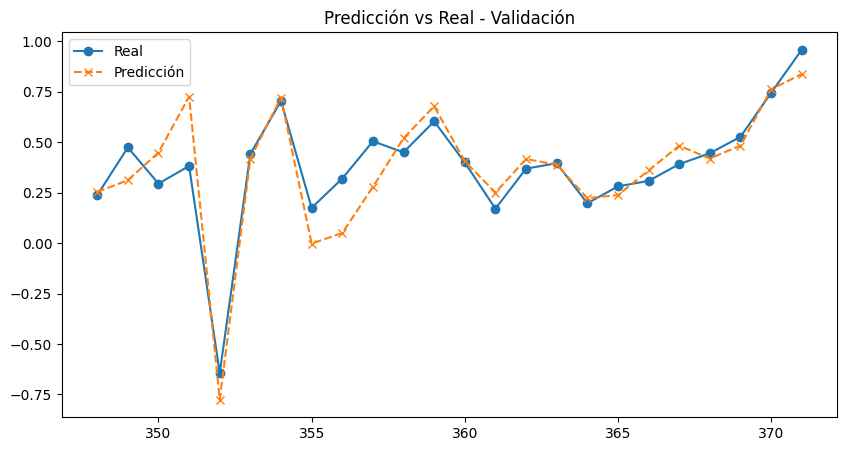

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(y_val.index, y_val, label="Real", marker='o')
plt.plot(y_val.index, y_pred_val, label="Predicción", linestyle="dashed", marker='x')
plt.legend()
plt.title("Predicción vs Real - Validación")
plt.show()

## PREDICCIÓN 2024

In [30]:
y_2024 = pd.DataFrame(y_2024)
predicciones_futuras = predecir_n_meses(sarimax_results, X_2024, exog_vars, 13)
predicciones_futuras['y_2024'] = y_2024['Inflación Mensual (%)'].values

predicciones_futuras

,Fecha,Predicción,y_2024
0,348,0.535843,0.234962
1,349,0.584248,0.679794
2,350,0.554427,0.488941
3,351,0.560485,0.278035
4,352,0.552167,0.161738
5,353,0.541007,0.322953
6,354,0.564708,0.643826
7,355,0.589631,0.434087
8,356,0.568586,0.045496
9,357,0.571414,-0.045475


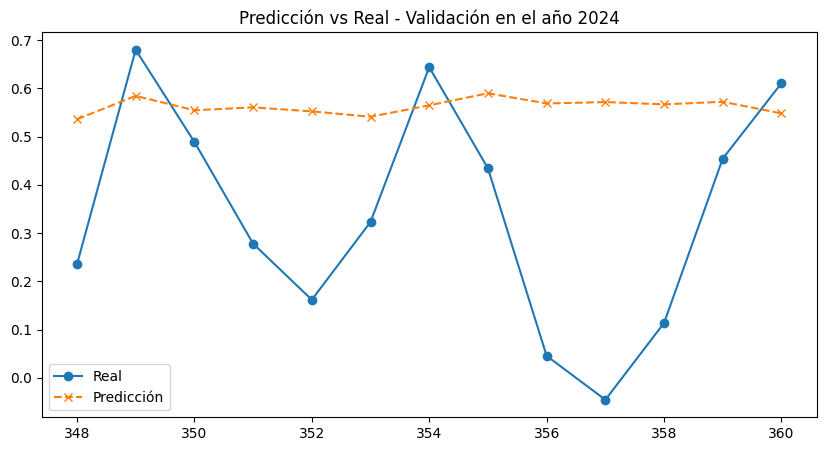

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(predicciones_futuras['Fecha'], predicciones_futuras['y_2024'], label="Real", marker='o')
plt.plot(predicciones_futuras['Fecha'], predicciones_futuras['Predicción'], label="Predicción", linestyle="dashed", marker='x')
plt.legend()
plt.title("Predicción vs Real - Validación en el año 2024")
plt.show()

## DESCARGAR MODELO

In [33]:
import pickle

# Guardar el modelo en un archivo .pkl
with open("SARIMAX_MAPE_75%.pkl", "wb") as file:
    pickle.dump(sarimax_results, file)

print("Modelo guardado exitosamente.")


Modelo guardado exitosamente.
